In [1]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt
from mpl_toolkits.mplot3d  import Axes3D

from scipy.integrate import odeint

import abc

In [2]:
# TODO: abtract away the diff operation. Try to understand when slicing/concat breaks the computational graph
# def diff(x, t, order=1):
#     ones = torch.ones_like(t)
#     der, = autograd.grad(x, t, create_graph=True, grad_outputs=ones)
#     for i in range(1, order):
#         der, = autograd.grad(der, t, create_graph=True, grad_outputs=ones)
#     return der

In [3]:
class FCNN(nn.Module):
    """
    A fully connected neural network.
    """
    def __init__(self, n_input_units, n_hidden_units, n_hidden_layers, actv):
        """
        :param n_input_units: number of units in the input layer
        :param n_hidden_units: number of hidden units in each hidden layer
        :param n_hidden_layers: number of hidden layers
        :param actv: the activation layer used in each hidden layer
        """
        super(FCNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(n_input_units, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, 1))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        return x

In [4]:
# TODO: arbitrary boundary condition
class DirichletBoundaryCondition:
    def __init__(self, x_min, x_min_val, x_max, x_max_val, y_min, y_min_val, y_max, y_max_val):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_val = x_max, x_max_val
        self.y_min, self.y_min_val = y_min, y_min_val
        self.y_max, self.y_max_val = y_max, y_max_val
    def enforce(self, u, x, y):
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        y_tilde = (y-self.y_min) / (self.y_max-self.y_min)
        Axy = (1-x_tilde)*self.x_min_val(y) + x_tilde*self.x_max_val(y) + \
              (1-y_tilde)*( self.y_min_val(x) - ((1-x_tilde)*self.y_min_val(0) + x_tilde*self.y_min_val(1)) ) + \
                 y_tilde *( self.y_max_val(x) - ((1-x_tilde)*self.y_max_val(0) + x_tilde*self.y_max_val(1)) )
        return Axy + x_tilde*(1-x_tilde)*y_tilde*(1-y_tilde)*u

In [5]:
class ExampleGenerator2D:
    def __init__(self, grid=[10, 10], xy_min=[0.0, 0.0],  xy_max=[1.0, 1.0], method='equally-spaced-noisy'):
        self.size = grid[0]*grid[1]
        
        if   method=='equally-spaced':
            x = torch.linspace(xy_min[0], xy_max[0], grid[0], requires_grad=True)
            y = torch.linspace(xy_min[1], xy_max[1], grid[1], requires_grad=True)
            grid_x, grid_y = torch.meshgrid(x, y)
            self.grid_x, self.grid_y = grid_x.flatten(), grid_y.flatten()
            
            self.get_examples = lambda: (self.grid_x, self.grid_y)
            
        elif method=='equally-spaced-noisy':
            x = torch.linspace(xy_min[0], xy_max[0], grid[0], requires_grad=True)
            y = torch.linspace(xy_min[1], xy_max[1], grid[1], requires_grad=True)
            grid_x, grid_y = torch.meshgrid(x, y)
            self.grid_x, self.grid_y = grid_x.flatten(), grid_y.flatten()
            
            self.noise_xmean = torch.zeros(self.size)
            self.noise_ymean = torch.zeros(self.size)
            self.noise_xstd  = torch.ones(self.size) * ((xy_max[0]-xy_min[0])/grid[0]) / 4.0
            self.noise_ystd  = torch.ones(self.size) * ((xy_max[1]-xy_min[1])/grid[1]) / 4.0
            self.get_examples = lambda: (
                self.grid_x + torch.normal(mean=self.noise_xmean, std=self.noise_xstd),
                self.grid_y + torch.normal(mean=self.noise_ymean, std=self.noise_ystd)
            )
        else:
            raise ValueError(f'Unknown method: {method}')

In [6]:
class Monitor2D:
    def __init__(self, xy_min, xy_max, check_every=100):
        %matplotlib notebook
        self.check_every = check_every
        self.fig = plt.figure(figsize=(18, 6))
        self.ax1 = self.fig.add_subplot(131)
        self.ax2 = self.fig.add_subplot(132)
        self.ax3 = self.fig.add_subplot(133)
        self.cb1, self.cb2 = None, None
        # input for neural network
        examplesgen = ExampleGenerator2D([32, 32], xy_min, xy_max, method='equally-spaced')
        xs_ann, ys_ann = examplesgen.get_examples()
        self.xs_ann, self.ys_ann = xs_ann.reshape(-1, 1), ys_ann.reshape(-1, 1)
        self.xy_ann = torch.cat((self.xs_ann, self.ys_ann), 1)
                                                            
    def check(self, net, pde, condition, loss_history):
        us = net(self.xy_ann)
        us = condition.enforce(us, self.xs_ann, self.ys_ann)
        
        # TODO: make the order of u, x, y more consistent later
        # TODO: abstract away the PDE formulation
        # Fuxy = pde(us, self.xs_ann, self.ys_ann)
        ones = torch.ones_like(us)
        dudx, = autograd.grad(    us, self.xs_ann, create_graph=True, grad_outputs=ones)
        dudxdx, = autograd.grad(dudx, self.xs_ann, create_graph=True, grad_outputs=ones)
        dudy, = autograd.grad(    us, self.ys_ann, create_graph=True, grad_outputs=ones)
        dudydy, = autograd.grad(dudy, self.ys_ann, create_graph=True, grad_outputs=ones)
        Fuxy = dudxdx + dudydy

        Fuxy = Fuxy.detach().numpy().flatten()
        us  = us.detach().numpy().flatten()

        self.ax1.clear()
        cax1 = self.ax1.matshow(us.reshape((32, 32)),   cmap='hot', interpolation='nearest')
        if self.cb1: self.cb1.remove()
        self.cb1 = self.fig.colorbar(cax1, ax=self.ax1)
        self.ax1.set_title('solution')
        
        self.ax2.clear()
        cax2 = self.ax2.matshow(Fuxy.reshape((32, 32)), cmap='hot', interpolation='nearest')
        if self.cb2: self.cb2.remove()
        self.cb2 = self.fig.colorbar(cax2, ax=self.ax2)
        self.ax2.set_title('residual')

        self.ax3.clear()
        self.ax3.plot(loss_history)
        self.ax3.set_title('loss during training')
        self.ax3.set_ylabel('loss')
        self.ax3.set_xlabel('epochs')
        self.ax3.set_yscale('log')

        self.fig.canvas.draw()

In [7]:
def solve_pde2D(pde, condition, xy_min, xy_max,
          net=None, example_generator=None, optimizer=None, criterion=None, batch_size=32, 
          max_epochs=100000, tol=1e-4,
          monitor=None):
    
    # default values
    if not net: 
        net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Tanh)
    if not example_generator: 
        example_generator = ExampleGenerator2D([32,32], xy_min, xy_max, method='equally-spaced-noisy')
    if not optimizer:
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    if not criterion:
        criterion = nn.MSELoss()
    if not monitor:
        monitor = Monitor2D(xy_min, xy_max, check_every=10)
    
    n_examples = example_generator.size
    if n_examples%batch_size != 0:
        # TODO: allow non-factor batch size
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    zeros = torch.zeros(batch_size)
    
    loss_history = []
    
    for epoch in range(max_epochs):
        loss_epoch = 0.0

        examples_x, examples_y = example_generator.get_examples()

        xs_batches = examples_x.reshape((n_batches, batch_size, 1))
        ys_batches = examples_y.reshape((n_batches, batch_size, 1))
        for xs, ys in zip(xs_batches, ys_batches): 
            xs, ys = xs.clone(), ys.clone()
            xys = torch.cat((xs, ys), 1) 
            us = net(xys)
            us = condition.enforce(us, xs, ys)
            
            # TODO: make the order of u, x, y more consistent later
            # TODO: abstract away the PDE formulation
            # Fuxy = pde(us, xs, ys)
            ones = torch.ones_like(us)
            dudx, = autograd.grad(    us, xs, create_graph=True, grad_outputs=ones)
            dudxdx, = autograd.grad(dudx, xs, create_graph=True, grad_outputs=ones)
            dudy, = autograd.grad(    us, ys, create_graph=True, grad_outputs=ones)
            dudydy, = autograd.grad(dudy, ys, create_graph=True, grad_outputs=ones)
            Fuxy = dudxdx + dudydy
            loss = criterion(Fuxy, zeros)
            loss_epoch += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_history.append(loss_epoch/n_batches)
        if loss_history[-1] < tol: break
        
        if epoch%monitor.check_every == 0:
            monitor.check(net, pde, condition, loss_history)
    
    def solution(xs, ys):
        pass
    if loss_history[-1] > tol:
        print('The solution has not converged.')
        
    return solution, loss_history

Consider Laplace's equation:

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

where

$$
u(x, 0) = x(1-x), u(0, y) = u(x, 1) = u(1, y) = 0
$$

TODO:
1. Abstract away the pde formulation and the diff operation. (Why the 'unused tensor' error?)
2. There some unimportant but annoying error when redrawing plots.
3. Unite the interface of ODE and 2D-PDE
4. Allow arbitrary boundary condition (https://sci-hub.tw/10.1109/tnn.2009.2020735)
5. Allow PDE of any number of independent variables

<IPython.core.display.Javascript object>


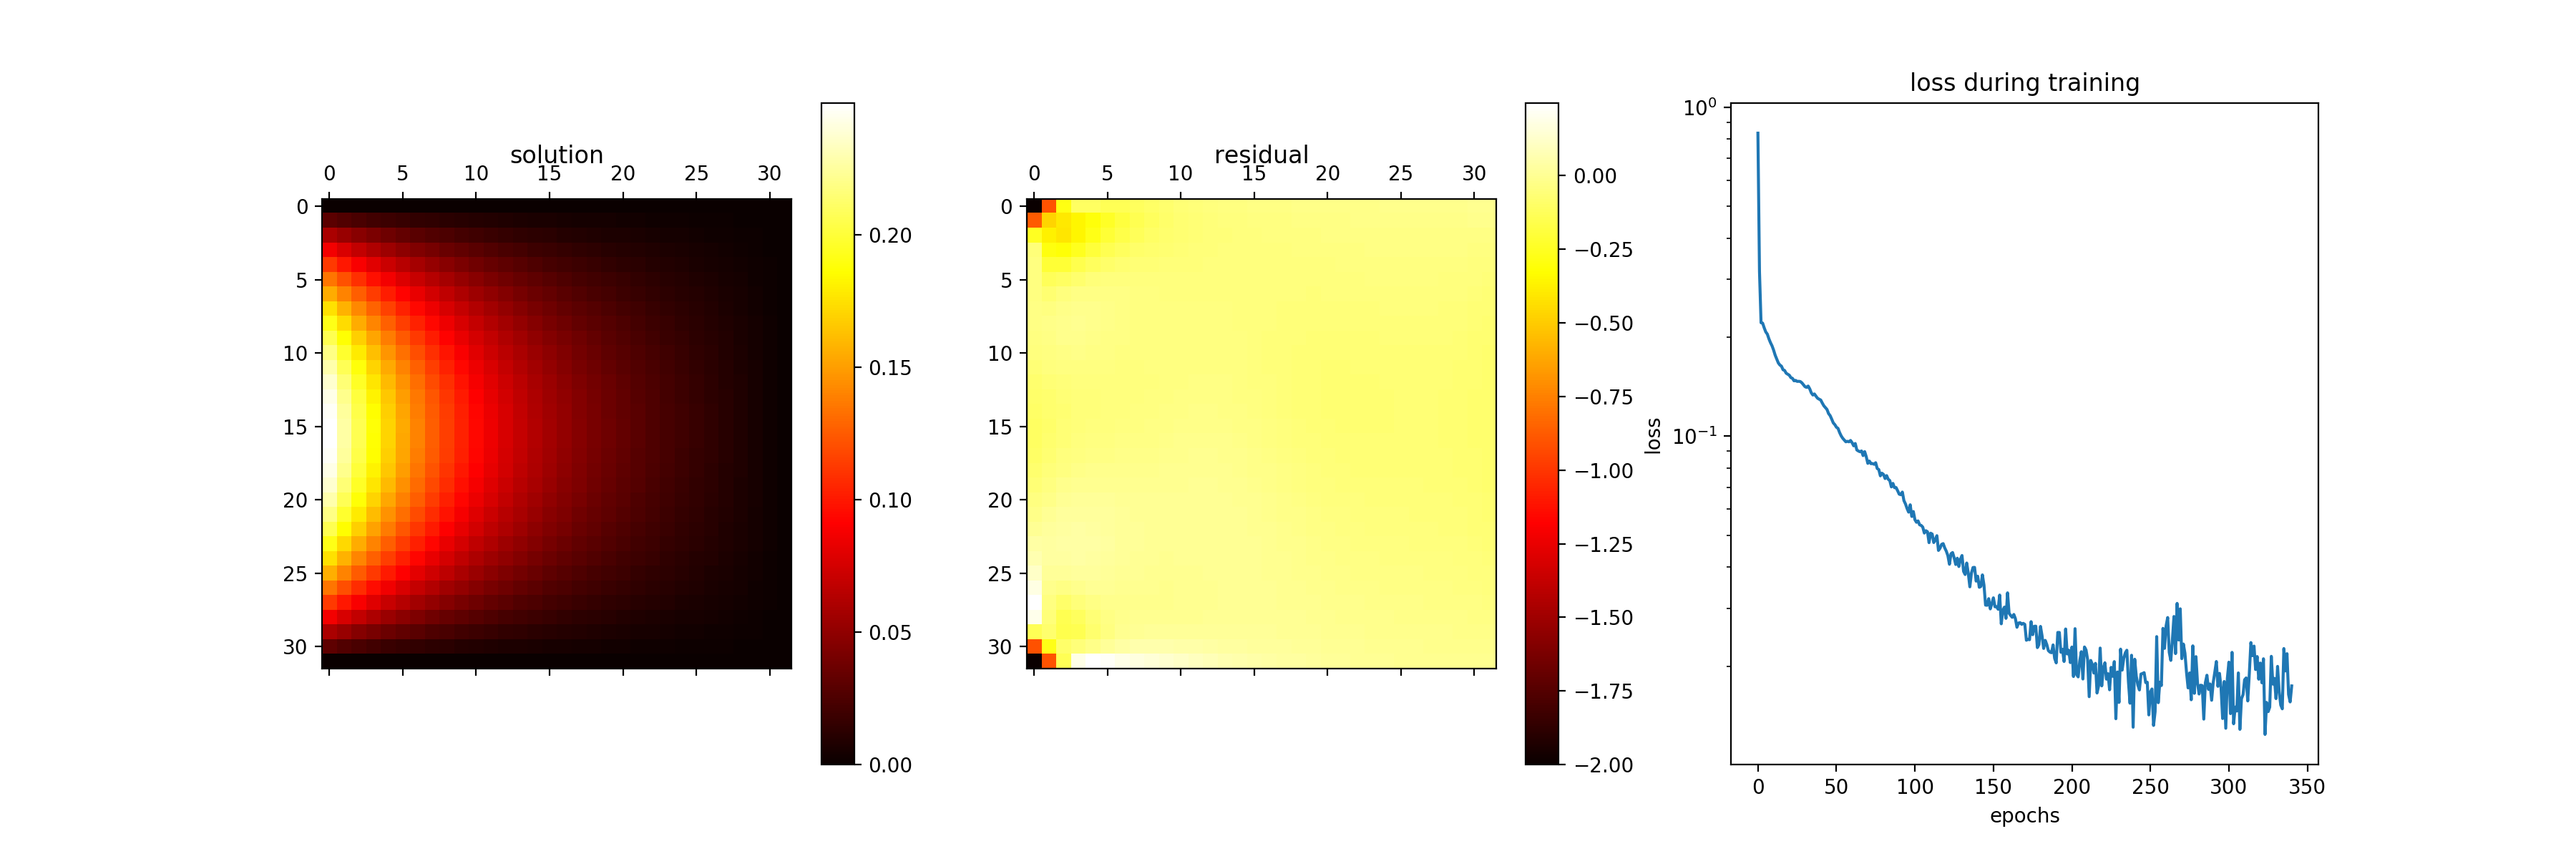

In [8]:
# laplace = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2)
BC = DirichletBoundaryCondition(x_min=0, x_min_val=lambda y: 0, 
                                x_max=1, x_max_val=lambda y: 0, 
                                y_min=0, y_min_val=lambda x: x*(1-x), 
                                y_max=1, y_max_val=lambda x: 0)
_, _ = solve_pde2D(pde=None, condition=BC, xy_min=[0, 0], xy_max=[1, 1], tol=1e-2)